<a href="https://colab.research.google.com/github/Ibizascop/Pokemon_Sounds/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn
import os
import sys
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import random
from tqdm import tqdm
#from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [3]:
#Using a pretrained Resnet50 model
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet50(
    include_top = False, weights='imagenet',    pooling='avg',
))

94773248/94765736 [==============================] - 2s 0us/step


In [4]:
# freezing weights for 1st layer
MyModel.layers[0].trainable = False

In [5]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

In [6]:
### with this all done lets write the iterrrative loop
def main(path):
    #Create a data frame to save the results
    Pokemons = []
    Flatten_spectros =[]
    Images = []
    list_spectros = os.listdir(path)
    for spec in tqdm(list_spectros):
        Pokemons.append(spec.replace(".png",""))
        imagePath = path + '/' + spec
        Images.append(imagePath)
        #Get features from model
        img = cv2.imread(imagePath)
        img = img = np.expand_dims(img, 0)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        extractedFeatures = MyModel.predict(img)
        extractedFeatures = np.array(extractedFeatures)
        Flatten_spectros.append(extractedFeatures.flatten())
    return Pokemons, Flatten_spectros,Images

In [7]:
### lets give the address of our Parent directory and start
path = "/content/drive/MyDrive/SPECTROS"
Pokemons, Flatten_spectros,Images= main(path)

100%|██████████| 5267/5267 [41:08<00:00,  2.13it/s]


In [12]:
#Enlever les spectrogrammes augmentés
dic = {"Pokemons":Pokemons,
       "Features":Flatten_spectros,
       "Image":Images}
df = pd.DataFrame(dic)
df = df[~df.Pokemons.str.contains("0|1|2|3|4|5")]
df.head()

,Pokemons,Features,Image
5,solgaleo,"[0.27257487, 0.0, 0.16442971, 0.0, 0.15715155,...",/content/drive/MyDrive/SPECTROS/solgaleo.png
11,sobble,"[0.6566502, 0.003765092, 0.0, 0.0, 0.95696825,...",/content/drive/MyDrive/SPECTROS/sobble.png
15,solrock,"[0.45388773, 0.0, 0.01993876, 0.0, 0.11164767,...",/content/drive/MyDrive/SPECTROS/solrock.png
22,solosis,"[0.9070679, 0.025425442, 0.083985955, 0.0, 0.6...",/content/drive/MyDrive/SPECTROS/solosis.png
27,spearow,"[0.5281935, 0.0, 0.0, 0.0, 0.14501846, 0.0, 0....",/content/drive/MyDrive/SPECTROS/spearow.png


In [30]:
list(df["Features"])

[array([0.27257487, 0.        , 0.16442971, ..., 0.02004509, 0.        ,
        0.8192543 ], dtype=float32),
 array([0.6566502 , 0.00376509, 0.        , ..., 0.02320054, 0.02282306,
        0.8646217 ], dtype=float32),
 array([0.45388773, 0.        , 0.01993876, ..., 0.00377412, 0.02108082,
        1.0279605 ], dtype=float32),
 array([0.9070679 , 0.02542544, 0.08398595, ..., 0.01264434, 0.02061483,
        0.7810449 ], dtype=float32),
 array([0.5281935 , 0.        , 0.        , ..., 0.        , 0.02547004,
        0.9758591 ], dtype=float32),
 array([0.8738981 , 0.        , 0.01667298, ..., 0.        , 0.        ,
        0.84046954], dtype=float32),
 array([0.67488027, 0.        , 0.00568932, ..., 0.00320963, 0.11127875,
        0.6922825 ], dtype=float32),
 array([0.6061078 , 0.        , 0.00951517, ..., 0.08125106, 0.        ,
        0.75069636], dtype=float32),
 array([0.5393019 , 0.        , 0.04591315, ..., 0.        , 0.08630269,
        1.0443877 ], dtype=float32),
 array([0.

In [41]:
#Vector with the features extracted from CNN 
Training_Feature_vector = np.array(list(df["Features"]))
Training_Feature_vector 


array([[2.7257487e-01, 0.0000000e+00, 1.6442971e-01, ..., 2.0045089e-02,
        0.0000000e+00, 8.1925428e-01],
       [6.5665019e-01, 3.7650920e-03, 0.0000000e+00, ..., 2.3200544e-02,
        2.2823064e-02, 8.6462170e-01],
       [4.5388773e-01, 0.0000000e+00, 1.9938760e-02, ..., 3.7741167e-03,
        2.1080816e-02, 1.0279605e+00],
       ...,
       [6.5019363e-01, 0.0000000e+00, 1.2979932e-01, ..., 7.6905997e-03,
        1.0731551e-03, 1.0936558e+00],
       [2.4352956e-01, 6.7986981e-03, 0.0000000e+00, ..., 5.4538320e-03,
        1.3935024e-02, 1.3267074e+00],
       [6.3557303e-01, 2.8219545e-02, 1.8753845e-02, ..., 2.0919302e-03,
        5.2101497e-02, 8.1400734e-01]], dtype=float32)

In [42]:
pca = PCA(n_components =200)
pca.fit(Training_Feature_vector)
pca


PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'cumulative explained variance')

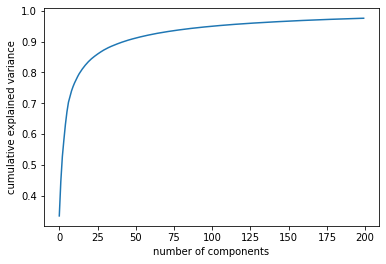

In [39]:
#Visualize optimal number of components to keep
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

In [58]:
final_df = pd.DataFrame(pca.transform(Training_Feature_vector))
final_df["Pokemons"] = list(df["Pokemons"])
final_df = final_df.set_index("Pokemons")
final_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
Pokemons,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
solgaleo,-8.035590,7.425567,2.951588,1.108543,-1.404353,-6.064350,-1.968538,0.996645,-3.484977,-1.343927,1.381926,0.320430,-1.518070,1.297153,2.291792,1.437592,-1.535016,-1.238700,-2.048448,-1.386879,-0.339300,0.725106,0.875668,0.057131,1.764073,0.528653,-0.002441,0.908100,0.555507,0.868318,0.129889,0.322652,-0.369568,-1.293069,-0.191605,-0.297635,0.061346,-0.491205,-0.177331,-0.542014,...,-0.019247,-0.330492,-0.412708,0.160594,-0.337146,0.208026,0.168953,0.361924,0.067392,-0.155694,0.072558,-0.152221,-0.017646,-0.112411,0.175150,0.101774,-0.255628,0.172939,0.335223,0.270933,-0.038338,0.206909,-0.214501,-0.032316,0.189098,-0.128508,-0.201139,0.118641,0.066588,0.077262,-0.233286,-0.037419,0.168524,0.104932,-0.111771,-0.057147,-0.223599,-0.313433,-0.126704,-0.089440
sobble,7.988099,-2.674106,-2.292609,0.223725,3.048164,-1.236647,3.821706,-0.899931,2.147726,1.110763,0.081497,-1.237772,1.278758,-3.410370,0.868525,-0.427861,-0.810462,-2.432254,-0.043807,0.165682,1.010924,-1.044652,1.272120,-1.285389,1.464126,1.354053,-0.352768,0.114083,-0.028787,0.215175,1.655865,1.013962,-0.607676,-0.376347,-1.110180,-0.293052,-0.624582,-0.116755,-0.069655,-0.047172,...,-0.066377,0.178368,-0.065104,-0.001161,0.154564,-0.203701,0.036191,0.001886,0.000697,-0.126200,0.224118,0.146780,-0.070992,0.090286,0.337060,0.096078,0.174419,0.124592,-0.210763,0.003722,0.165360,-0.033943,0.119872,0.074120,-0.164990,0.038213,-0.549391,-0.039193,0.265397,-0.033830,-0.324583,-0.094344,-0.024733,-0.114136,0.013031,0.133188,0.119971,-0.150301,0.115762,-0.170971
solrock,2.515978,-7.022437,-6.292981,-0.328035,2.660174,2.748127,-0.179824,1.261353,-0.406002,-0.400618,0.665346,0.017062,0.732561,0.800529,1.086488,-0.088292,1.004829,1.031088,-0.402518,0.276230,-0.815182,-0.892526,-0.019782,-0.293901,0.005739,-1.069062,0.898450,0.650448,-0.889232,-0.562172,-0.316583,-0.574286,0.664006,-0.631762,-0.382167,0.291377,0.281586,0.198264,-0.256399,-0.085804,...,0.197314,0.154263,0.076241,0.316680,0.014428,-0.136225,0.279306,0.007154,-0.011241,-0.208536,0.157918,0.196253,-0.150220,-0.008405,-0.184017,0.098073,-0.100001,-0.047898,0.257421,-0.341879,0.291730,-0.135163,0.055998,-0.103344,-0.338853,0.026891,0.168173,0.092857,-0.056977,-0.181571,-0.138958,0.112877,0.044494,0.179576,-0.033276,0.163745,0.045129,0.270061,-0.006540,-0.053428
solosis,9.249195,-9.347870,1.557268,6.040207,7.361426,-3.009690,0.103139,-0.332811,-1.580486,-3.599301,-1.618988,-1.845222,-0.841189,1.562763,0.002839,-0.807790,-1.632274,1.193645,2.219638,1.446740,0.224748,0.031801,0.358020,-0.396610,0.257875,0.457329,0.420117,-0.478088,1.868286,1.629696,-0.346378,-0.538002,0.155194,0.046836,0.212465,-0.290080,-1.527041,0.166341,-0.476619,-1.051966,...,-0.306591,0.156975,-0.329329,-0.120200,0.228976,0.080947,-0.153900,0.239605,-0.100473,-0.297133,-0.008595,-0.087203,-0.188562,-0.304647,-0.182921,0.090950,-0.229552,0.123650,0.248947,-0.110631,0.406130,-0.432541,-0.036513,0.275181,-0.074243,-0.285863,0.112717,-0.137328,0.464567,0.274579,0.001732,0.273434,0.137556,0.215959,-0.168201,0.155648,-0.058950,-0.146253,0.229076,0.045265
spearow,0.670853,5.907433,-1.219359,-6.422547,1.850726,2.607922,2.552872,1.628231,-1.915895,-1.486195,0.491899,-0.628497,-1.561501,-0.316142,2.142127,0.161319,-0.900059,-0.095284,-1.424523,-0.040165,1.317852,-0.347707,-1.869672,-1.011117,0.932433,0.692848,0.002697,-0.863256,-0.504805,-0.271362,0.109420,0.449607,-0.606607,0.503190,0.803912,-0.891099,-0.817840,1.096818,0.554924,-0.074789,...,0.187239,-0.361850,0.328152,-0.158899,0.085842,0.379270,0.249929,-0.023230,-0.217213,-0.091005,0.389596,-0.059903,0.080196,0.129811,-0.279269,-0.149422,0.

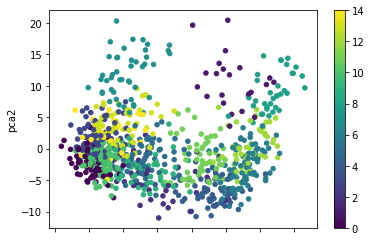

In [92]:
######################################################
#        Kmeans Clustering                 #
######################################################
kmeans = KMeans(n_clusters=15).fit(final_df)
#Visualization
reduced_data = PCA(n_components=2).fit_transform(final_df)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

final_df["Cluster_kmeans"]=list(kmeans.labels_)
#Plot Kmeans on PCA of 2 
ax1 = results.plot.scatter(x='pca1',y='pca2',c=final_df['Cluster_kmeans'],colormap='viridis').get_figure()



In [ ]:
#Save plot
ax1.savefig("/content/drive/MyDrive/kmeans.png")

In [93]:
final_df["Cluster_kmeans"]=list(kmeans.labels_)
final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,Cluster_kmeans
Pokemons,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
solgaleo,-8.035590,7.425567,2.951588,1.108543,-1.404353,-6.064350,-1.968538,0.996645,-3.484977,-1.343927,1.381926,0.320430,-1.518070,1.297153,2.291792,1.437592,-1.535016,-1.238700,-2.048448,-1.386879,-0.339300,0.725106,0.875668,0.057131,1.764073,0.528653,-0.002441,0.908100,0.555507,0.868318,0.129889,0.322652,-0.369568,-1.293069,-0.191605,-0.297635,0.061346,-0.491205,-0.177331,-0.542014,...,-0.330492,-0.412708,0.160594,-0.337146,0.208026,0.168953,0.361924,0.067392,-0.155694,0.072558,-0.152221,-0.017646,-0.112411,0.175150,0.101774,-0.255628,0.172939,0.335223,0.270933,-0.038338,0.206909,-0.214501,-0.032316,0.189098,-0.128508,-0.201139,0.118641,0.066588,0.077262,-0.233286,-0.037419,0.168524,0.104932,-0.111771,-0.057147,-0.223599,-0.313433,-0.126704,-0.089440,3
sobble,7.988099,-2.674106,-2.292609,0.223725,3.048164,-1.236647,3.821706,-0.899931,2.147726,1.110763,0.081497,-1.237772,1.278758,-3.410370,0.868525,-0.427861,-0.810462,-2.432254,-0.043807,0.165682,1.010924,-1.044652,1.272120,-1.285389,1.464126,1.354053,-0.352768,0.114083,-0.028787,0.215175,1.655865,1.013962,-0.607676,-0.376347,-1.110180,-0.293052,-0.624582,-0.116755,-0.069655,-0.047172,...,0.178368,-0.065104,-0.001161,0.154564,-0.203701,0.036191,0.001886,0.000697,-0.126200,0.224118,0.146780,-0.070992,0.090286,0.337060,0.096078,0.174419,0.124592,-0.210763,0.003722,0.165360,-0.033943,0.119872,0.074120,-0.164990,0.038213,-0.549391,-0.039193,0.265397,-0.033830,-0.324583,-0.094344,-0.024733,-0.114136,0.013031,0.133188,0.119971,-0.150301,0.115762,-0.170971,11
solrock,2.515978,-7.022437,-6.292981,-0.328035,2.660174,2.748127,-0.179824,1.261353,-0.406002,-0.400618,0.665346,0.017062,0.732561,0.800529,1.086488,-0.088292,1.004829,1.031088,-0.402518,0.276230,-0.815182,-0.892526,-0.019782,-0.293901,0.005739,-1.069062,0.898450,0.650448,-0.889232,-0.562172,-0.316583,-0.574286,0.664006,-0.631762,-0.382167,0.291377,0.281586,0.198264,-0.256399,-0.085804,...,0.154263,0.076241,0.316680,0.014428,-0.136225,0.279306,0.007154,-0.011241,-0.208536,0.157918,0.196253,-0.150220,-0.008405,-0.184017,0.098073,-0.100001,-0.047898,0.257421,-0.341879,0.291730,-0.135163,0.055998,-0.103344,-0.338853,0.026891,0.168173,0.092857,-0.056977,-0.181571,-0.138958,0.112877,0.044494,0.179576,-0.033276,0.163745,0.045129,0.270061,-0.006540,-0.053428,4
solosis,9.249195,-9.347870,1.557268,6.040207,7.361426,-3.009690,0.103139,-0.332811,-1.580486,-3.599301,-1.618988,-1.845222,-0.841189,1.562763,0.002839,-0.807790,-1.632274,1.193645,2.219638,1.446740,0.224748,0.031801,0.358020,-0.396610,0.257875,0.457329,0.420117,-0.478088,1.868286,1.629696,-0.346378,-0.538002,0.155194,0.046836,0.212465,-0.290080,-1.527041,0.166341,-0.476619,-1.051966,...,0.156975,-0.329329,-0.120200,0.228976,0.080947,-0.153900,0.239605,-0.100473,-0.297133,-0.008595,-0.087203,-0.188562,-0.304647,-0.182921,0.090950,-0.229552,0.123650,0.248947,-0.110631,0.406130,-0.432541,-0.036513,0.275181,-0.074243,-0.285863,0.112717,-0.137328,0.464567,0.274579,0.001732,0.273434,0.137556,0.215959,-0.168201,0.155648,-0.058950,-0.146253,0.229076,0.045265,4
spearow,0.670853,5.907433,-1.219359,-6.422547,1.850726,2.607922,2.552872,1.628231,-1.915895,-1.486195,0.491899,-0.628497,-1.561501,-0.316142,2.142127,0.161319,-0.900059,-0.095284,-1.424523,-0.040165,1.317852,-0.347707,-1.869672,-1.011117,0.932433,0.692848,0.002697,-0.863256,-0.504805,-0.271362,0.109420,0.449607,-0.606607,0.503190,0.803912,-0.891099,-0.817840,1.096818,0.554924,-0.074789,...,-0.361850,0.328152,-0.158899,0.085842,0.379270,0.249929,-0.023230,-0.217213,-0.091005,0.389596,-0.059903,0.080196,0.129811,-0.279269,-0.149422,0.388108,-0.306811,-0.036683,-

In [155]:
#Plot some examples of the clustering
def plot_examples(cluster_number) :
  data = final_df[final_df["Cluster_kmeans"] == cluster_number].sample(frac=1).index.to_list()
  #plt.title("Cluster number {}, plotting some examples".format(cluster_number))
  for i in range(0,4) :
    try :
      plt.subplot(2,2,i+1)
      plt.tight_layout()
      plt.title("Sound of {}".format(data[i]))
      img = cv2.imread('/content/drive/MyDrive/SPECTROS/'+data[i]+".png")
      plt.imshow(img)
    except:
      pass
      

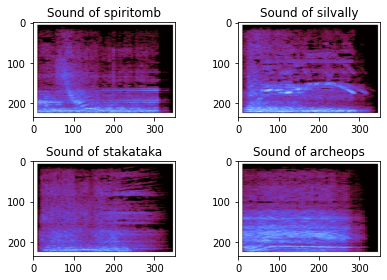

In [166]:
plot_examples(3)

In [160]:
plt.close("all")

In [161]:
final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,Cluster_kmeans
Pokemons,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
solgaleo,-8.035590,7.425567,2.951588,1.108543,-1.404353,-6.064350,-1.968538,0.996645,-3.484977,-1.343927,1.381926,0.320430,-1.518070,1.297153,2.291792,1.437592,-1.535016,-1.238700,-2.048448,-1.386879,-0.339300,0.725106,0.875668,0.057131,1.764073,0.528653,-0.002441,0.908100,0.555507,0.868318,0.129889,0.322652,-0.369568,-1.293069,-0.191605,-0.297635,0.061346,-0.491205,-0.177331,-0.542014,...,-0.330492,-0.412708,0.160594,-0.337146,0.208026,0.168953,0.361924,0.067392,-0.155694,0.072558,-0.152221,-0.017646,-0.112411,0.175150,0.101774,-0.255628,0.172939,0.335223,0.270933,-0.038338,0.206909,-0.214501,-0.032316,0.189098,-0.128508,-0.201139,0.118641,0.066588,0.077262,-0.233286,-0.037419,0.168524,0.104932,-0.111771,-0.057147,-0.223599,-0.313433,-0.126704,-0.089440,3
sobble,7.988099,-2.674106,-2.292609,0.223725,3.048164,-1.236647,3.821706,-0.899931,2.147726,1.110763,0.081497,-1.237772,1.278758,-3.410370,0.868525,-0.427861,-0.810462,-2.432254,-0.043807,0.165682,1.010924,-1.044652,1.272120,-1.285389,1.464126,1.354053,-0.352768,0.114083,-0.028787,0.215175,1.655865,1.013962,-0.607676,-0.376347,-1.110180,-0.293052,-0.624582,-0.116755,-0.069655,-0.047172,...,0.178368,-0.065104,-0.001161,0.154564,-0.203701,0.036191,0.001886,0.000697,-0.126200,0.224118,0.146780,-0.070992,0.090286,0.337060,0.096078,0.174419,0.124592,-0.210763,0.003722,0.165360,-0.033943,0.119872,0.074120,-0.164990,0.038213,-0.549391,-0.039193,0.265397,-0.033830,-0.324583,-0.094344,-0.024733,-0.114136,0.013031,0.133188,0.119971,-0.150301,0.115762,-0.170971,11
solrock,2.515978,-7.022437,-6.292981,-0.328035,2.660174,2.748127,-0.179824,1.261353,-0.406002,-0.400618,0.665346,0.017062,0.732561,0.800529,1.086488,-0.088292,1.004829,1.031088,-0.402518,0.276230,-0.815182,-0.892526,-0.019782,-0.293901,0.005739,-1.069062,0.898450,0.650448,-0.889232,-0.562172,-0.316583,-0.574286,0.664006,-0.631762,-0.382167,0.291377,0.281586,0.198264,-0.256399,-0.085804,...,0.154263,0.076241,0.316680,0.014428,-0.136225,0.279306,0.007154,-0.011241,-0.208536,0.157918,0.196253,-0.150220,-0.008405,-0.184017,0.098073,-0.100001,-0.047898,0.257421,-0.341879,0.291730,-0.135163,0.055998,-0.103344,-0.338853,0.026891,0.168173,0.092857,-0.056977,-0.181571,-0.138958,0.112877,0.044494,0.179576,-0.033276,0.163745,0.045129,0.270061,-0.006540,-0.053428,4
solosis,9.249195,-9.347870,1.557268,6.040207,7.361426,-3.009690,0.103139,-0.332811,-1.580486,-3.599301,-1.618988,-1.845222,-0.841189,1.562763,0.002839,-0.807790,-1.632274,1.193645,2.219638,1.446740,0.224748,0.031801,0.358020,-0.396610,0.257875,0.457329,0.420117,-0.478088,1.868286,1.629696,-0.346378,-0.538002,0.155194,0.046836,0.212465,-0.290080,-1.527041,0.166341,-0.476619,-1.051966,...,0.156975,-0.329329,-0.120200,0.228976,0.080947,-0.153900,0.239605,-0.100473,-0.297133,-0.008595,-0.087203,-0.188562,-0.304647,-0.182921,0.090950,-0.229552,0.123650,0.248947,-0.110631,0.406130,-0.432541,-0.036513,0.275181,-0.074243,-0.285863,0.112717,-0.137328,0.464567,0.274579,0.001732,0.273434,0.137556,0.215959,-0.168201,0.155648,-0.058950,-0.146253,0.229076,0.045265,4
spearow,0.670853,5.907433,-1.219359,-6.422547,1.850726,2.607922,2.552872,1.628231,-1.915895,-1.486195,0.491899,-0.628497,-1.561501,-0.316142,2.142127,0.161319,-0.900059,-0.095284,-1.424523,-0.040165,1.317852,-0.347707,-1.869672,-1.011117,0.932433,0.692848,0.002697,-0.863256,-0.504805,-0.271362,0.109420,0.449607,-0.606607,0.503190,0.803912,-0.891099,-0.817840,1.096818,0.554924,-0.074789,...,-0.361850,0.328152,-0.158899,0.085842,0.379270,0.249929,-0.023230,-0.217213,-0.091005,0.389596,-0.059903,0.080196,0.129811,-0.279269,-0.149422,0.388108,-0.306811,-0.036683,-

In [162]:
final_df.to_csv("/content/drive/MyDrive/kmeans.csv")